<a href="https://colab.research.google.com/github/amarabuco/seriestemporais/blob/main/ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
!pip install -U statsmodels

# Imports

In [96]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

In [97]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [99]:
mpl.rcParams['figure.figsize'] = [20, 5]

In [100]:
from datetime import datetime
custom_time_parser = lambda x: datetime.strptime(x, "%H:%M:%S.%f").time() if '.' in x else datetime.strptime(x, "%H:%M:%S").time()

In [101]:
custom_time_parser('01:02:03.200000')

datetime.time(1, 2, 3, 200000)

In [102]:
custom_time_parser('01:02:04')

datetime.time(1, 2, 4)

In [103]:
train_orig = pd.read_csv('../dataset/case_28_subsampled_200ms_train.csv', parse_dates=['Time'], date_parser=custom_time_parser)
test = pd.read_csv('../dataset/case_28_subsampled_200ms_test.csv', parse_dates=['Time'], date_parser=custom_time_parser)
train_orig

,Time,EEG,BIS
0,00:00:00,NaN,NaN
1,00:00:00.200000,NaN,NaN
2,00:00:00.400000,NaN,NaN
3,00:00:00.600000,NaN,NaN
4,00:00:00.800000,NaN,NaN
...,...,...,...
16724,00:55:44.800000,0.01526,80.0
16725,00:55:45,0.01526,80.0
16726,00:55:45.200000,0.01526,80.0
16727,00:55:45.400000,5.99817,80.0


In [104]:
train_orig.index = train_orig['Time']
train_orig.drop(columns=['Time'], inplace=True)
test.index = test['Time']
test.drop(columns=['Time'], inplace=True)
train_orig

,EEG,BIS
Time,,
00:00:00,NaN,NaN
00:00:00.200000,NaN,NaN
00:00:00.400000,NaN,NaN
00:00:00.600000,NaN,NaN
00:00:00.800000,NaN,NaN
...,...,...
00:55:44.800000,0.01526,80.0
00:55:45,0.01526,80.0
00:55:45.200000,0.01526,80.0


## Validation Split (25%) = 1/3 of 75% of train set (the last 1/3)

In [105]:
25/(100*0.75)

0.3333333333333333

In [106]:
100*0.75*1/3

25.0

In [107]:
train = train_orig.iloc[:int(len(train_orig) * 2/3)]['EEG']
val = train_orig.iloc[int(len(train_orig) * 2/3):]['EEG']
test = test['EEG']

print(train.shape)
print(val.shape)

(11152,)
(5577,)


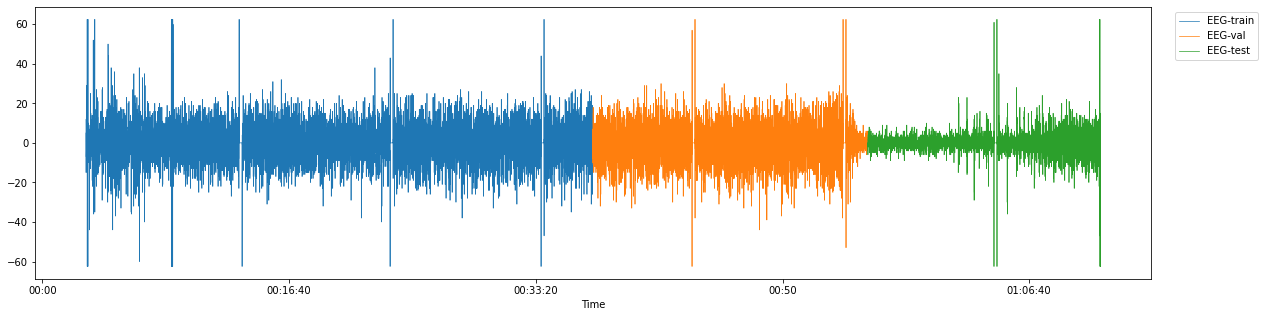

In [108]:
linewidth = 0.7
ax = train.rename(f'{train.name}-train').plot(linewidth = linewidth)
ax = val.rename(f'{train.name}-val').plot(ax=ax, linewidth = linewidth)
test.rename(f'{test.name}-test').plot(ax=ax, linewidth = linewidth)
plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")

In [109]:
print(f'Train: {len(train.index)}')
print(f'Val: {len(val.index)}')
print(f'Test: {len(test.index)}')
total = len(train.index) + len(val.index) + len(test.index)
print(f'\nTrain: {len(train.index)/total*100:.3f}%')
print(f'Val: {len(val.index)/total*100:.3f}%')
print(f'Test: {len(test.index)/total*100:.3f}%')

Train: 11152
Val: 5577
Test: 5577

Train: 49.996%
Val: 25.002%
Test: 25.002%


d:\Users\dav\anaconda3\envs\pos\lib\site-packages\numpy\core\_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


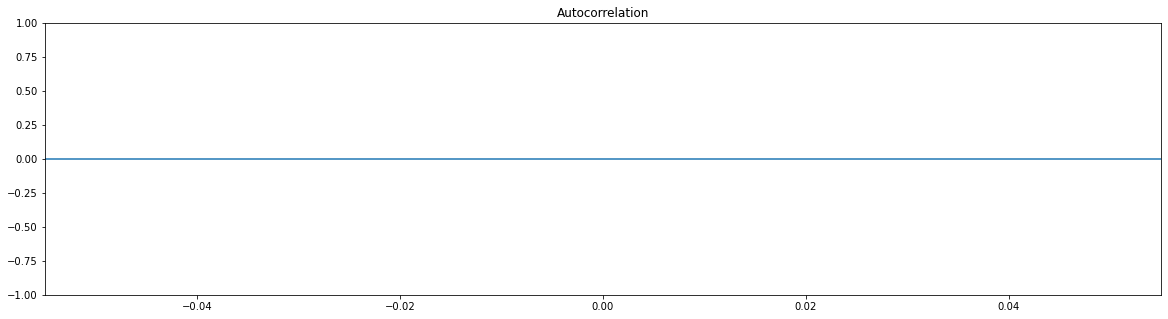

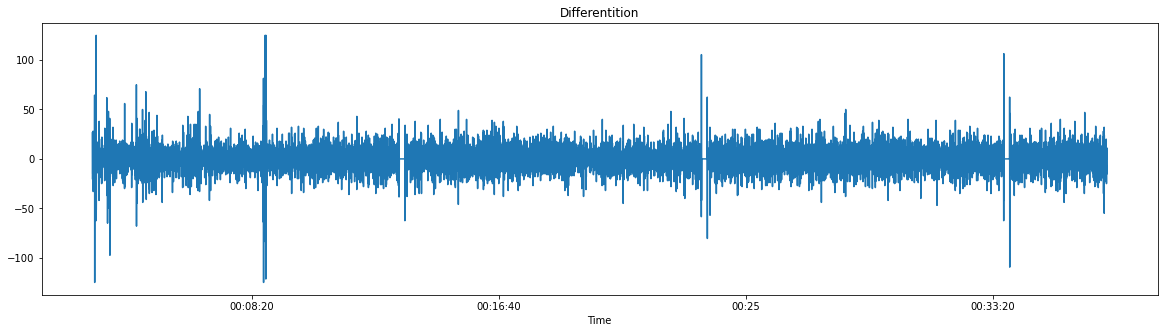

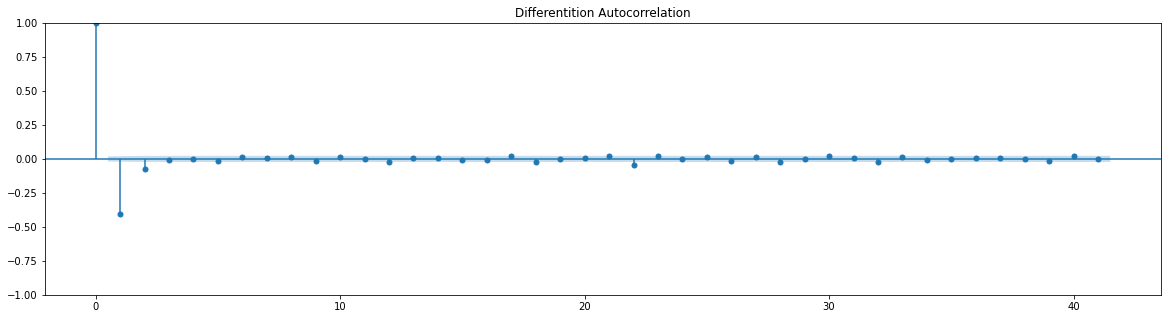

In [110]:
plot_acf(train);
plt.show()
train.diff().dropna().plot();
plt.title("Differentiation")
plt.show()
plot_acf(train.diff().dropna());
plt.title("Differentiation Autocorrelation")
plt.show()

### Análise

Filling not available data backward and forward

In [111]:
train = train.fillna(method='bfill').fillna(method='ffill')
train

Time
00:00:00            4.99084
00:00:00.200000     4.99084
00:00:00.400000     4.99084
00:00:00.600000     4.99084
00:00:00.800000     4.99084
                     ...   
00:37:09.400000   -15.00305
00:37:09.600000    -4.99084
00:37:09.800000    -4.99084
00:37:10            5.99817
00:37:10.200000    -8.98962
Name: EEG, Length: 11152, dtype: float64

<AxesSubplot:xlabel='Time'>

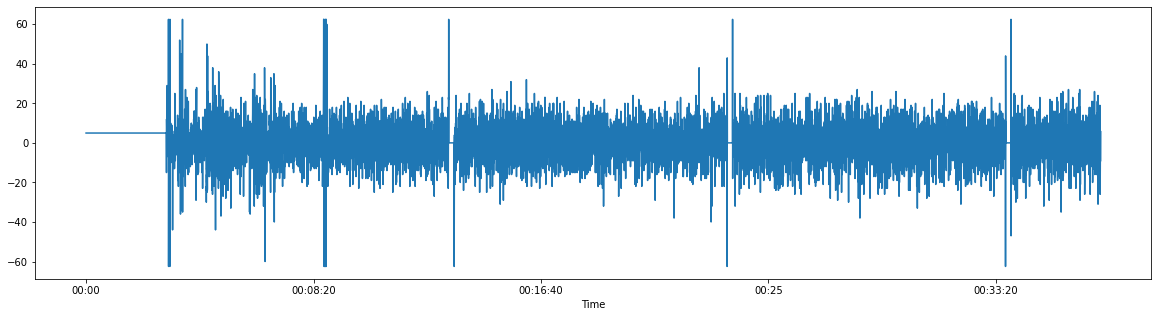

In [112]:
train.plot()

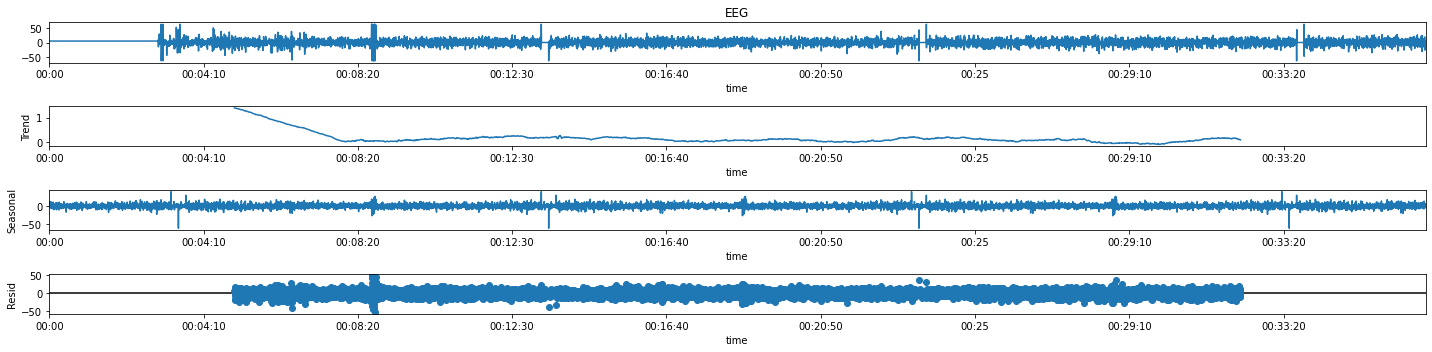

In [113]:
frequency = 200 # nanoseconds
minutes = 10 # 10 Minutes sazonality
train_decomp = tsa.seasonal_decompose(train, period=int(minutes*60*1000/frequency))
train_decomp.plot();

#### Stationarity

<AxesSubplot:xlabel='Time'>

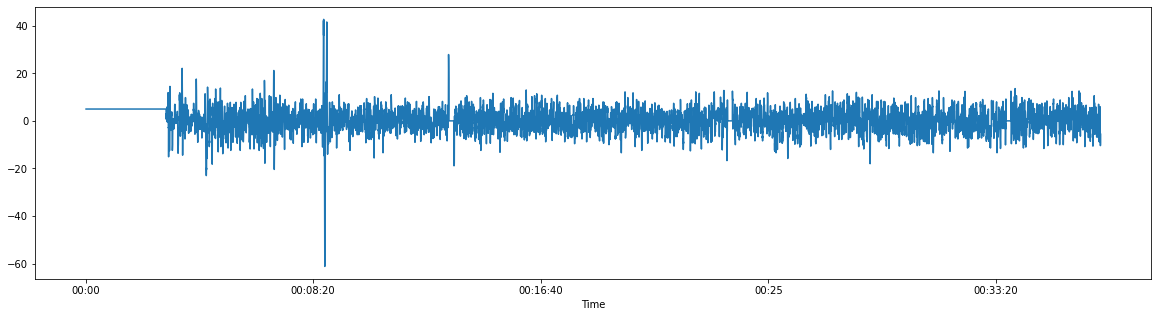

In [114]:
train.rolling(5).mean().plot()

<AxesSubplot:ylabel='Frequency'>

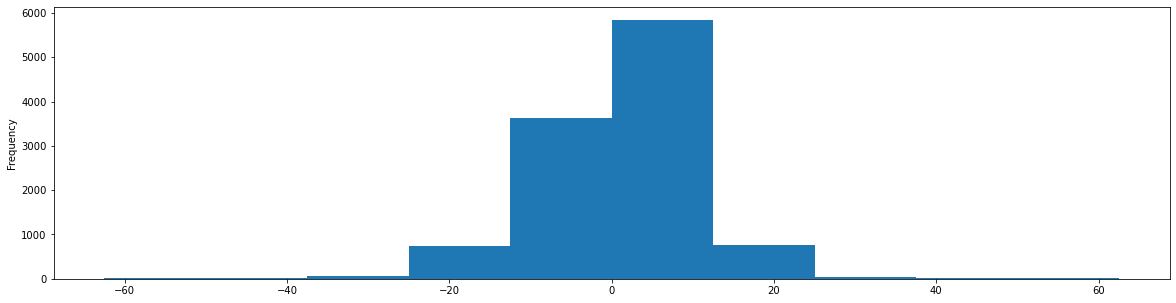

In [115]:
train.plot.hist()

#### Diferentiation 1st order (d)

<AxesSubplot:xlabel='Time'>

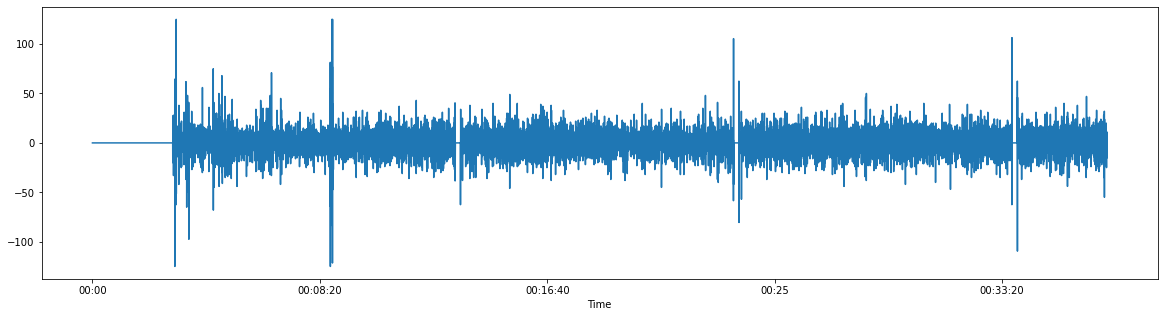

In [116]:
train.diff().plot()

<AxesSubplot:ylabel='Frequency'>

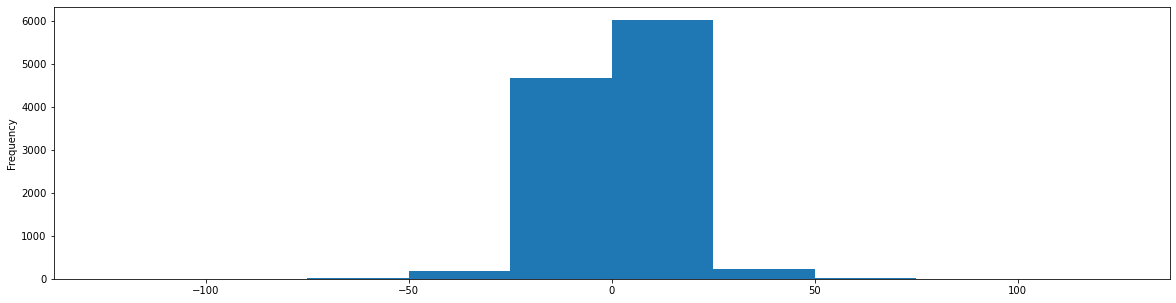

In [117]:
train.diff().plot.hist()

In [118]:
eegd1 = train.diff().dropna()

#### Autocorrelation

A correlation of a variable with itself at different times
is known as autocorrelation or serial correlation.

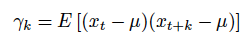

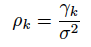

In [119]:
train.to_frame().corrwith(train.shift(-1))

EEG    0.162938
dtype: float64

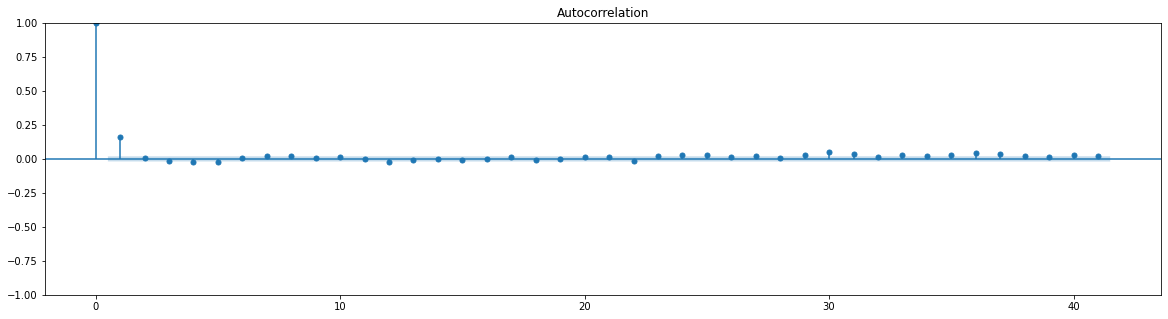

In [120]:
plot_acf(train);

In [121]:
train.to_frame().corrwith(eegd1.shift(-1))

EEG   -0.646931
dtype: float64

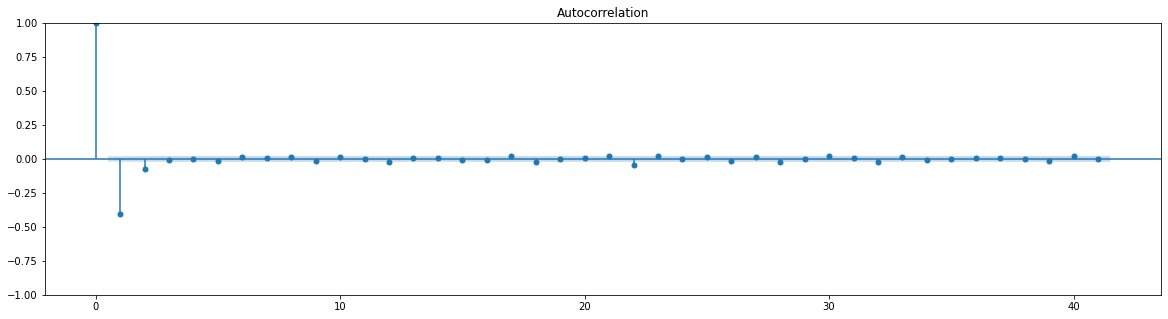

In [122]:
plot_acf(eegd1);

#### Partial Correlation

The partial autocorrelation at lag k is the correlation that
results after removing the effect of any correlations due to the terms at shorter
lags.

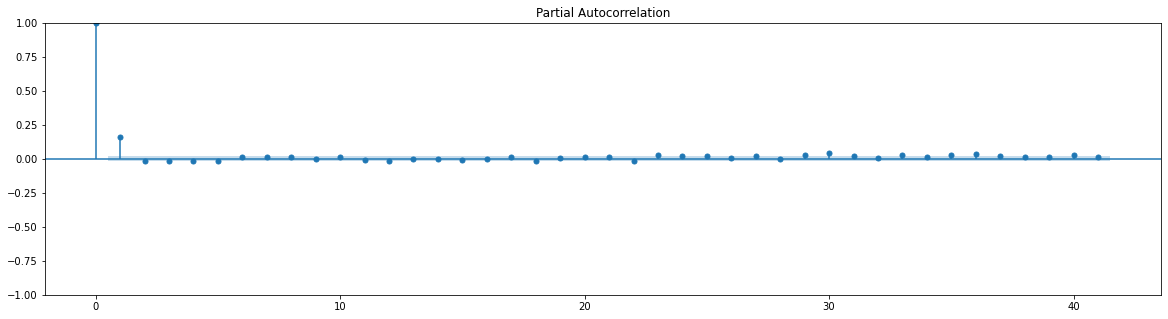

In [123]:
plot_pacf(train, method='ywm');

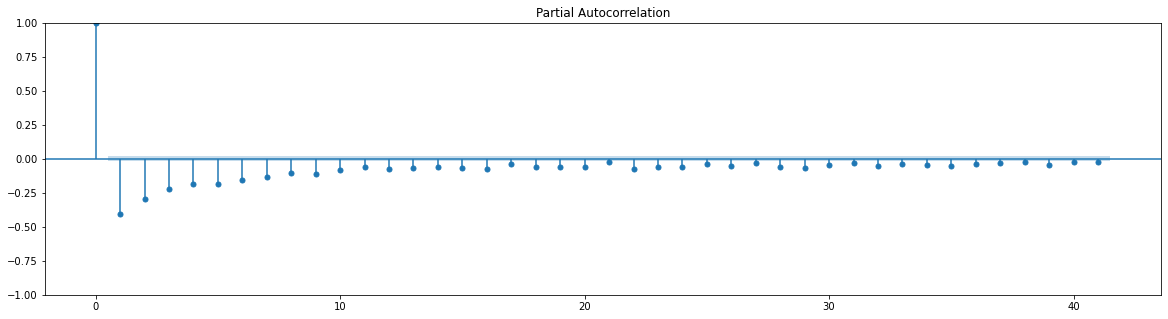

In [124]:
plot_pacf(eegd1, method='ywm');

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

### Feature Engineering

In [125]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [126]:
X_train = get_lags(train.to_frame(), 5)
X_val = get_lags(val.to_frame(), 5)
X_test = get_lags(test.to_frame(), 5)

In [127]:
X_train.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:00:01,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.200000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.400000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.600000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.800000,4.99084,4.99084,4.99084,4.99084,4.99084


In [128]:
X_val.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:37:11.400000,-4.99084,7.00549,-1.99939,-8.98962,-9.99695
00:37:11.600000,-7.00549,-4.99084,7.00549,-1.99939,-8.98962
00:37:11.800000,-8.01282,-7.00549,-4.99084,7.00549,-1.99939
00:37:12,-4.99084,-8.01282,-7.00549,-4.99084,7.00549
00:37:12.200000,-3.00671,-4.99084,-8.01282,-7.00549,-4.99084


In [129]:
X_test.head()

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:55:46.800000,-1.99939,-1.99939,-5.99817,-3.00671,0.01526
00:55:47,0.01526,-1.99939,-1.99939,-5.99817,-3.00671
00:55:47.200000,4.01404,0.01526,-1.99939,-1.99939,-5.99817
00:55:47.400000,0.01526,4.01404,0.01526,-1.99939,-1.99939
00:55:47.600000,-1.99939,0.01526,4.01404,0.01526,-1.99939


In [130]:
y_train = train.to_frame().reindex(X_train.index)
y_val = val.to_frame().reindex(X_val.index)
y_test = test.to_frame().reindex(X_test.index)

In [131]:
y_train.head()

,EEG
Time,
00:00:01,4.99084
00:00:01.200000,4.99084
00:00:01.400000,4.99084
00:00:01.600000,4.99084
00:00:01.800000,4.99084


In [132]:
y_val.head()

,EEG
Time,
00:37:11.400000,-7.00549
00:37:11.600000,-8.01282
00:37:11.800000,-4.99084
00:37:12,-3.00671
00:37:12.200000,-5.99817


In [133]:
y_test.head()

,EEG
Time,
00:55:46.800000,0.01526
00:55:47,4.01404
00:55:47.200000,0.01526
00:55:47.400000,-1.99939
00:55:47.600000,1.99939


### KNN

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_nca_illustration_001.png)

![KNN](https://scikit-learn.org/stable/_images/sphx_glr_plot_regression_001.png)

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor

Hyperparameters:

* K 
* weights
* distance

In [134]:
import numpy as np

In [135]:
print(f'Train size: {len(train.index.values)}')
print(f'Val size: {len(val.index.values)}')

Train size: 11152
Val size: 5577


In [136]:
train_plus_val_indices = np.append(train.index.values,val.index.values)
len(train_plus_val_indices)

16729

In [137]:
train_plus_val_indices[:10]

array([datetime.time(0, 0), datetime.time(0, 0, 0, 200000),
       datetime.time(0, 0, 0, 400000), datetime.time(0, 0, 0, 600000),
       datetime.time(0, 0, 0, 800000), datetime.time(0, 0, 1),
       datetime.time(0, 0, 1, 200000), datetime.time(0, 0, 1, 400000),
       datetime.time(0, 0, 1, 600000), datetime.time(0, 0, 1, 800000)],
      dtype=object)

In [138]:
X_train.values

array([[  4.99084,   4.99084,   4.99084,   4.99084,   4.99084],
       [  4.99084,   4.99084,   4.99084,   4.99084,   4.99084],
       [  4.99084,   4.99084,   4.99084,   4.99084,   4.99084],
       ...,
       [ -4.99084, -15.00305, -25.99206,  -0.99206,   5.99817],
       [ -4.99084,  -4.99084, -15.00305, -25.99206,  -0.99206],
       [  5.99817,  -4.99084,  -4.99084, -15.00305, -25.99206]])

In [139]:
X_val.values

array([[-4.99084,  7.00549, -1.99939, -8.98962, -9.99695],
       [-7.00549, -4.99084,  7.00549, -1.99939, -8.98962],
       [-8.01282, -7.00549, -4.99084,  7.00549, -1.99939],
       ...,
       [ 0.01526,  0.01526, -0.99206, -0.99206,  0.99206],
       [ 0.01526,  0.01526,  0.01526, -0.99206, -0.99206],
       [ 5.99817,  0.01526,  0.01526,  0.01526, -0.99206]])

In [140]:
X = pd.concat([X_train,X_val])
X

,EEG-1,EEG-2,EEG-3,EEG-4,EEG-5
Time,,,,,
00:00:01,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.200000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.400000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.600000,4.99084,4.99084,4.99084,4.99084,4.99084
00:00:01.800000,4.99084,4.99084,4.99084,4.99084,4.99084
...,...,...,...,...,...
00:55:44.800000,-0.99206,-0.99206,0.99206,3.00671,0.01526
00:55:45,0.01526,-0.99206,-0.99206,0.99206,3.00671
00:55:45.200000,0.01526,0.01526,-0.99206,-0.99206,0.99206


In [141]:
X_train.index

Index([       00:00:01, 00:00:01.200000, 00:00:01.400000, 00:00:01.600000,
       00:00:01.800000,        00:00:02, 00:00:02.200000, 00:00:02.400000,
       00:00:02.600000, 00:00:02.800000,
       ...
       00:37:08.400000, 00:37:08.600000, 00:37:08.800000,        00:37:09,
       00:37:09.200000, 00:37:09.400000, 00:37:09.600000, 00:37:09.800000,
              00:37:10, 00:37:10.200000],
      dtype='object', name='Time', length=11147)

In [142]:
y = pd.concat([y_train,y_val])
y

,EEG
Time,
00:00:01,4.99084
00:00:01.200000,4.99084
00:00:01.400000,4.99084
00:00:01.600000,4.99084
00:00:01.800000,4.99084
...,...
00:55:44.800000,0.01526
00:55:45,0.01526
00:55:45.200000,0.01526


In [73]:
SEED = 42

In [94]:
import numpy as np
from sklearn.model_selection import PredefinedSplit
X_example = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_example = np.array([1, 2, 3, 4, 5, 6])

split_index = [-1 if index <= len(X)*2/3 else 0 for index in range(len(X))]
pds = PredefinedSplit(test_fold = split_index)
print(pds)

for train_index_example, val_index_example in pds.split(X_example):
    print("TRAIN:", train_index_example, "VAL:", val_index_example)
    X_train_example, X_val_example = X_example[train_index_example], X_example[val_index_example]
    y_train_example, y_val_example = y_example[train_index_example], y_example[val_index_example]

PredefinedSplit(test_fold=array([-1, -1, -1, -1, -1,  0]))
TRAIN: [0 1 2 3 4] VAL: [5]


In [154]:
len(split_index)

16719

In [155]:
pd.Series(split_index).value_counts()

-1    11147
 0     5572
dtype: int64

In [315]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: %2.3f' % mse)
    return mse

def MAE(y_true,y_pred):    
     mae = mean_absolute_error(y_true, y_pred)
     print('MAE: %2.3f' % mae)
     return mae

def R2(y_true,y_pred):    
     r2 = r2_score(y_true, y_pred)
     print('R2: %2.3f' % r2)
     return r2

def three_score(y_true,y_pred):    
    score = MAE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    score = R2(y_true,y_pred)
    score = MSE(y_true,y_pred) #set score here and not below if using MSE in GridCV
    return score

def three_scorer():
    # return make_scorer(two_score, greater_is_better=True) # change for false if using MSE
    return make_scorer(three_score, greater_is_better=False) # change for false if using MSE


In [316]:
import random   

In [317]:
# Create a list where train data indices are -1 and validation data indices are 0 (2/3 = train and 1/3 = validation)
split_index = [-1 if index <= len(X)*2/3 else 0 for index in range(len(X))]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

for train_index, val_index in pds.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [373]:
def print_results_original_series(best_model, X_train, y_train, X_val, y_val, X_test, y_test):
    X_test = X_test.fillna(method='bfill').fillna(method='ffill')
    y_test = y_test.fillna(method='bfill').fillna(method='ffill')

    ax = None
    ax = y_train.rename(columns={'EEG': "train_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_train).flatten(), index=y_train.index, name="train_pred").plot(ax=ax, linewidth=linewidth)
    ax = y_val.rename(columns={'EEG': "val_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_val).flatten(), index=y_val.index, name="val_pred").plot(ax=ax, linewidth=linewidth)
    ax = y_test.rename(columns={'EEG': "test_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_test).flatten(), index=y_test.index, name="test_pred").plot(ax=ax, linewidth=linewidth)
    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")
    r2  = r2_score(best_model.predict(X_test), y_test)
    mse = mean_squared_error(best_model.predict(X_test), y_test)
    mae = mean_absolute_error(best_model.predict(X_test), y_test)
    print(f"Test R2: {r2}")
    print(f"Test mse: {mse}")
    print(f"Test mae: {mae}")

In [375]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from scipy.stats import uniform

def train_validate_model(model, X_train_val, y_train_val, X_test, y_test, model_name=None, distributions={}, repetitions=10,
                        print_result=print_results_original_series):

    results = []
    best_models = []
    
    # Create a list where train data indices are -1 and validation data indices are 0 (2/3 = train and 1/3 = validation)
    split_index = [-1 if index <= len(X)*2/3 else 0 for index in range(len(X))]

    # Use the list to create PredefinedSplit
    pds = PredefinedSplit(test_fold = split_index)

    for train_index, val_index in pds.split(X_train_val):
        X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
        y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    for repetition in range(repetitions):
        print(f"Repetition: {str(repetition)}")
        SEED = random.seed(repetition)
        randGridS = RandomizedSearchCV(model, param_distributions=distributions, random_state = SEED, scoring=three_scorer(), 
                                       cv=pds, n_jobs=-1, verbose=2, return_train_score=True)
        res = randGridS.fit(X, y)
        best_params = res.best_params_
        best_model = res.best_estimator_
        best_score = res.best_score_
        r2  = r2_score(best_model.predict(X_val), y_val)
        mse = mean_squared_error(best_model.predict(X_val), y_val)
        mae = mean_absolute_error(best_model.predict(X_val), y_val)
        print(f"Best params: {best_params}")
        print(f"R2: {r2}")
        print(f"mse: {mse}")
        print(f"mae: {mae}")

        best_models.append(res)
        results.append({'model': model_name,
                        'repetition': repetition,
                        'val_r2': r2,
                        'val_mse': mse, 
                        'val_mae': mae,
                        'params': best_params})
        
    dataframe = pd.DataFrame(results).sort_values(['val_r2', 'val_mse', 'val_mae'], ascending=[False, True, True])
    print(f"Best params of all repetitions: {dataframe.iloc[0].params}")
    # SEED = random.seed(dataframe.iloc[0].repetition)
    best_model = clone(model).set_params(**resultados.iloc[0].params)
    best_model.fit(X, y)
    ax = None
    linewidth = 2

    print_result(best_model, X_train, y_train, X_val, y_val, X_test, y_test)
    return best_model, dataframe
    

In [ ]:
distributions = {'n_neighbors': np.random.randint(1, 1000, size=20),
                 'weights': ['uniform', 'distance']}

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

In [352]:
distributions = {'n_neighbors':  [int(x) for x in np.linspace(start = 1, stop = 1000, num = 10)],
                 'weights': ['uniform', 'distance']}

In [353]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor()

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: 0.9830193037991567
mse: 1.4555014820561532
mae: 0.02902948200724957
Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 334}
R2: 0.9832068100157922
mse: 1.4395328478507399
mae: 0.03722519662197009
Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 445}
R2: 0.9832068100157922
mse: 1.4395328478507399
mae: 0.03722519662197009
Repetition: 3
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: 0.9830193037991567
mse: 1.4555014820561532
mae: 0.02902948200724957
Repetition: 4
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: 0.9830193037991567
mse: 1.4555014820561532
mae: 

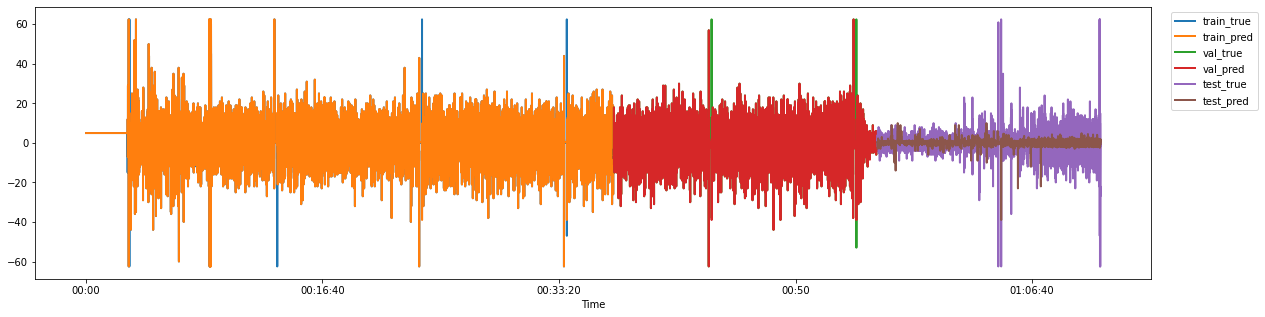

In [354]:
res, resultados = train_validate_model(model, X, y, X_test, y_test, 'KNN', distributions)

In [356]:
resultados

,model,repetition,val_r2,val_mse,val_mae,params
1,KNN,1,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
2,KNN,2,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
6,KNN,6,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 334}"
8,KNN,8,0.983207,1.439533,0.037225,"{'weights': 'distance', 'n_neighbors': 445}"
0,KNN,0,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
3,KNN,3,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
4,KNN,4,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
5,KNN,5,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
7,KNN,7,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"
9,KNN,9,0.983019,1.455501,0.029029,"{'weights': 'distance', 'n_neighbors': 223}"


E agora?

In [366]:
X_d1 = X.diff().fillna(method='bfill').fillna(method='ffill')
y_d1 = y.diff().fillna(method='bfill').fillna(method='ffill')
X_test_d1 = X_test.diff().fillna(method='bfill').fillna(method='ffill')
y_test_d1 = y_test.diff().fillna(method='bfill').fillna(method='ffill')

In [367]:
distributions

{'n_neighbors': [1, 112, 223, 334, 445, 556, 667, 778, 889, 1000],
 'weights': ['uniform', 'distance']}

In [378]:
def print_results_diff_series(best_model, X_train, y_train, X_val, y_val, X_test, y_test):
    X_test = X_test.fillna(method='bfill').fillna(method='ffill')
    y_test = y_test.fillna(method='bfill').fillna(method='ffill')

    ax = None
    ax = y_train.rename(columns={'EEG': "train_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_train).flatten(), index=y_train.index, name="train_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    ax = y_val.rename(columns={'EEG': "val_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_val).flatten(), index=y_val.index, name="val_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    ax = y_test.rename(columns={'EEG': "test_true"}).plot(ax=ax, linewidth=linewidth)
    ax = pd.Series(best_model.predict(X_test).flatten(), index=y_test.index, name="test_pred").cumsum().plot(ax=ax, linewidth=linewidth)
    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper right")
    r2  = r2_score(best_model.predict(X_test), y_test)
    mse = mean_squared_error(best_model.predict(X_test), y_test)
    mae = mean_absolute_error(best_model.predict(X_test), y_test)
    print(f"Test R2: {r2}")
    print(f"Test mse: {mse}")
    print(f"Test mae: {mae}")

Repetition: 0
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 334}
R2: -85.66282025948145
mse: 177.07859987916126
mae: 10.014200593359202
Repetition: 1
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: -77.52918918408162
mse: 177.35294592966838
mae: 10.014284166144057
Repetition: 2
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 445}
R2: -91.01991805793548
mse: 177.00406584918994
mae: 10.007956352900587
Repetition: 3
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: -77.52918918408162
mse: 177.35294592966838
mae: 10.014284166144057
Repetition: 4
Fitting 1 folds for each of 10 candidates, totalling 10 fits
Best params: {'weights': 'distance', 'n_neighbors': 223}
R2: -77.52918918408162
mse: 177.35294592966838
mae: 10.0

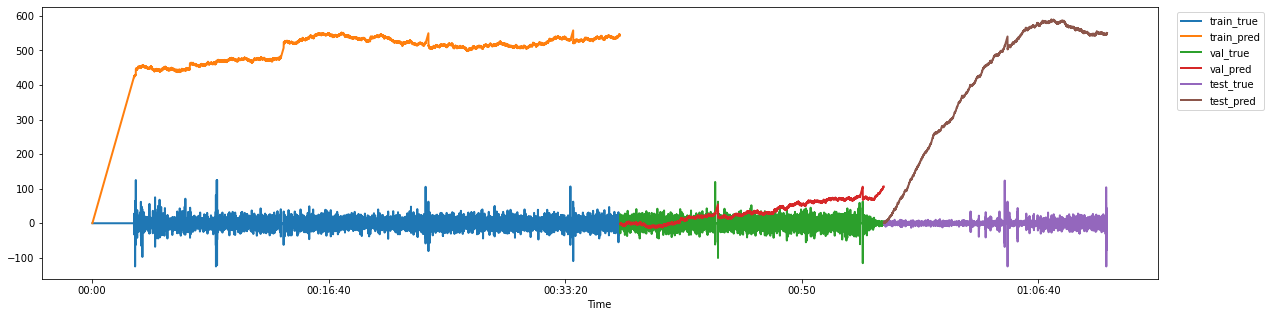

In [379]:
neighd1 = KNeighborsRegressor()

res_neigh_d1, resultados_neigh_d1 = train_validate_model(neighd1, X_d1, y_d1, X_test_d1, y_test_d1, 'KNN_d1', distributions,
                                                         print_result=print_results_diff_series)

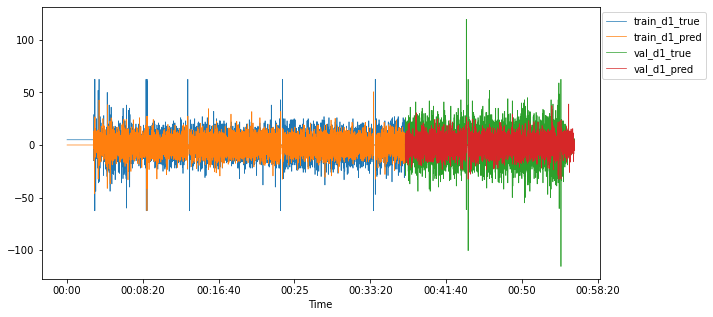

In [393]:
ax = None
linewidth = 0.7
ax = y_train.rename(columns={'EEG': "train_d1_true"}).plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_train_d1).flatten(), index=y_train_d1.index, name="train_d1_pred").plot(ax=ax, linewidth=linewidth)
ax = y_val_d1.rename(columns={'EEG': "val_d1_true"}).plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_val_d1).flatten(), index=y_val_d1.index, name="val_d1_pred").plot(ax=ax, linewidth=linewidth)
plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")

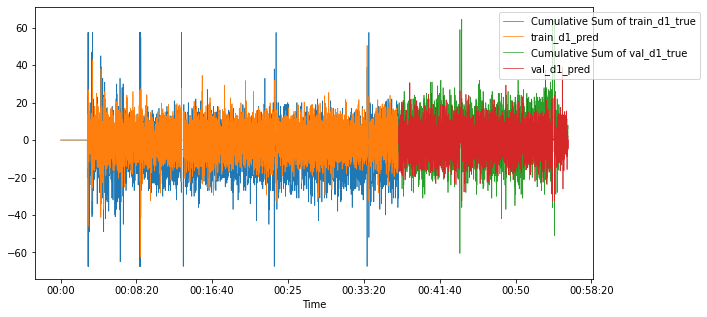

In [392]:
ax = None
linewidth = 0.7
ax = y_train_d1.rename(columns={'EEG': "Cumulative Sum of train_d1_true"}).cumsum().plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_train_d1).flatten(), index=y_train_d1.index, name="train_d1_pred").plot(ax=ax, linewidth=linewidth)
ax = y_val_d1.rename(columns={'EEG': "Cumulative Sum of val_d1_true"}).cumsum().plot(ax=ax, linewidth=linewidth)
ax = pd.Series(neigh.predict(X_val_d1).flatten(), index=y_val_d1.index, name="val_d1_pred").plot(ax=ax, linewidth=linewidth)
plt.legend(bbox_to_anchor=(1.2, 1), loc="upper right")

Qual o problema dessa previsão?

 * Erro acumulado (problema em multi step recursivo)

In [382]:
pred_one = y_val.shift(1).reset_index(drop=True).add(pd.Series(neighd1.predict(X_val_d1).flatten(), name='EEG'),axis=0)

In [383]:
pred_one

,EEG
0,NaN
1,-17.255582
2,-0.086321
3,-4.813738
4,-10.034704
...,...
5570,-2.994496
5571,2.002478
5572,3.765586
5573,-4.447926


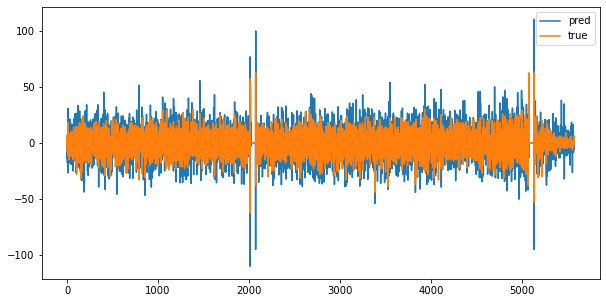

In [384]:
fig, ax = plt.subplots()
ax.plot(pred_one, label='pred')
ax.plot(y_val.reset_index(drop=True), label='true')
plt.legend()

In [385]:
pred_one

,EEG
0,NaN
1,-17.255582
2,-0.086321
3,-4.813738
4,-10.034704
...,...
5570,-2.994496
5571,2.002478
5572,3.765586
5573,-4.447926


In [387]:
print('EEG pred_one - KNN model Results')
print(r2_score(pred_one.iloc[1:-1], y_val.iloc[1:-1]))
print(mean_squared_error(pred_one.iloc[1:-1], y_val.iloc[1:-1]))
print(mean_absolute_error(pred_one.iloc[1:-1], y_val.iloc[1:-1]))
results['KNN D1 ONE'] = {'r2':r2_score(pred_one.iloc[1:-1], y_val.iloc[1:-1]), \
                 'mse': mean_squared_error(pred_one.iloc[1:-1], y_val.iloc[1:-1]), 
                 'mae': mean_absolute_error(pred_one.iloc[1:-1], y_val.iloc[1:-1])}


EEG pred_one - KNN model Results
-0.9422565150745388
378.13346420224957
14.490483838948538


In [388]:
residuos = neighd1.predict(X_val_d1).flatten() - y_val_d1.reset_index(drop=True).values.flatten()

<AxesSubplot:>

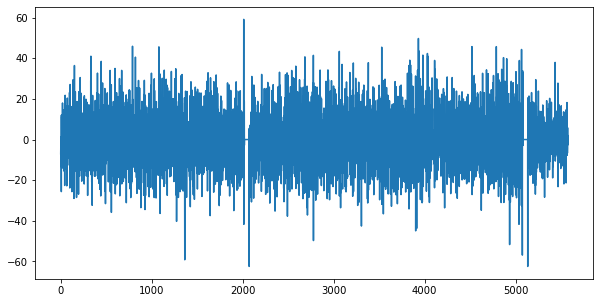

In [389]:
pd.Series(residuos).plot()

<AxesSubplot:ylabel='Density'>

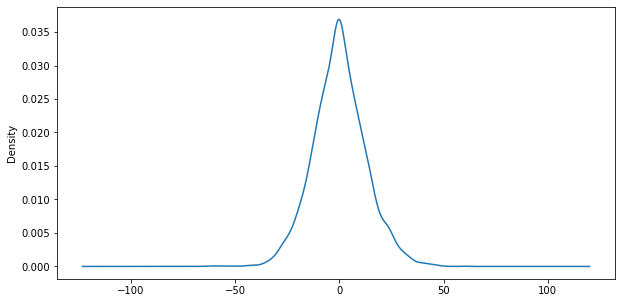

In [390]:
pd.Series(residuos).plot.kde()

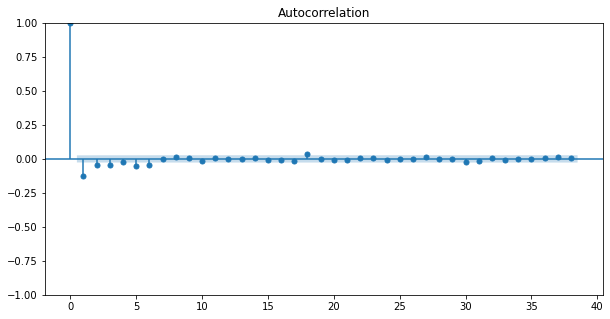

In [391]:
plot_acf(residuos);

### SVR

In [85]:
from sklearn.svm import SVR

![SVC](https://scikit-learn.org/stable/_images/sphx_glr_plot_separating_hyperplane_001.png)

![SVR](https://scikit-learn.org/stable/_images/sphx_glr_plot_svm_regression_001.png)

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR

In [ ]:
distributions = {'C': ,
                 'epsilon': ,
                 'kernel': }

In [86]:
regr = SVR()

In [87]:
res, resultados = train_validate_model(SVR(), X, y, X_test, y_test, 'SVR', distributions)

d:\Users\dav\anaconda3\envs\pos\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(epsilon=0.2, kernel='linear')

In [95]:
print('El Nino - SVR model Results')
print(r2_score(regr.predict(X_test), y_test))
print(mean_squared_error(regr.predict(X_test), y_test))
print(mean_absolute_error(regr.predict(X_test), y_test))
results['SVR'] = {'r2':r2_score(regr.predict(X_test), y_test), \
                 'mse': mean_squared_error(regr.predict(X_test), y_test), 
                 'mae': mean_absolute_error(regr.predict(X_test), y_test)}

El Nino - SVR model Results
-8.599835673898674
28.087809531214823
2.7669177369304196


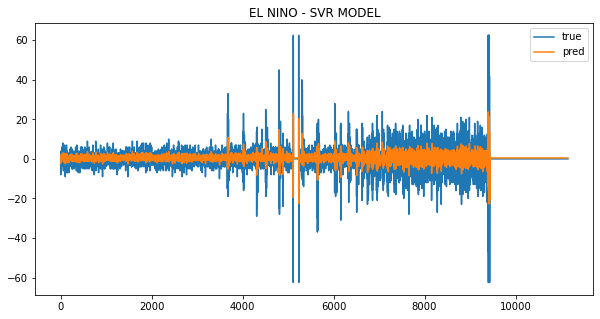

In [97]:
fig, ax = plt.subplots()
ax.plot(y_test.reset_index(drop=True), label='true')
ax.plot(regr.predict(X_test), label='pred')
plt.title('EL NINO - SVR MODEL')
plt.legend()

In [583]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from scipy.stats import uniform

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if index in train.index else 0 for index in train_plus_val_indices]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

In [98]:

parameters = {'kernel':['linear','rbf'], 'C':[0.1,1,10]}
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
regr2 = SVR()
regrGS = RandomizedSearchCV(regr2, parameters, cv=pds, n_jobs=-1)

res = regrGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)
print('SVR GS - model Results')
print('r2' , r2_score(res.predict(X_test), y_test))
print('mse' ,mean_squared_error(res.predict(X_test), y_test))
print('mae', mean_absolute_error(res.predict(X_test), y_test))
results['SVRGS'] = {'r2':r2_score(res.predict(X_test), y_test), \
                 'mse': mean_squared_error(res.predict(X_test), y_test), 
                 'mae': mean_absolute_error(res.predict(X_test), y_test)}
%%time

In [99]:
pd.DataFrame(results)

,KNN,KNN D1,KNN D1 ONE,SVR,SVRGS
r2,-0.764809,-0.764809,-0.684845,-8.599836,-10.187646
mse,48.807563,48.807563,109.502158,28.087810,26.675165
mae,4.318033,4.318033,5.790172,2.766918,2.693775


In [ ]:
X = get_lags(co2, 5)
y = co2.reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)

In [ ]:
regrco2 = SVR(kernel='linear')
regrco2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='linear')

In [ ]:
print('SVR GS - model Results')
print('r2' , r2_score(regrco2.predict(X_test), y_test))
print('mse' ,mean_squared_error(regrco2.predict(X_test), y_test))
print('mae', mean_absolute_error(regrco2.predict(X_test), y_test))
resultsco2['SVRGS'] = {'r2':r2_score(regrco2.predict(X_test), y_test), \
                 'mse': mean_squared_error(regrco2.predict(X_test), y_test), 
                 'mae': mean_absolute_error(regrco2.predict(X_test), y_test)}


SVR GS - model Results
r2 0.9901566847904703
mse 0.23719501168606366
mae 0.37552955540609895


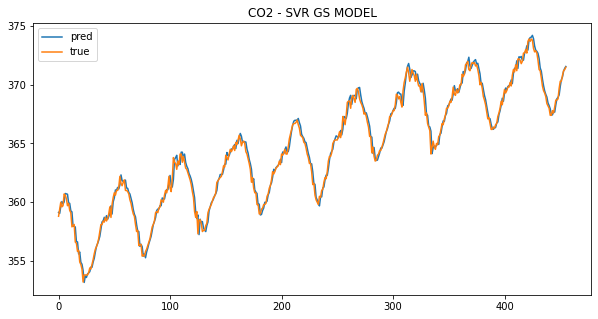

In [ ]:
fig, ax = plt.subplots()
ax.plot(regrco2.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('CO2 - SVR GS MODEL')
plt.legend()

In [ ]:
pd.DataFrame(resultsco2)

,KNN,KNN D1,KNN D1 ONE,SVRGS
r2,-45.318270,-45.318270,0.985402,0.990157
mse,52.555341,52.555341,0.353482,0.237195
mae,5.847865,5.847865,0.455441,0.375530


Overfitting ?

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

In [ ]:
len(y)

2279

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250,300,350,384], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

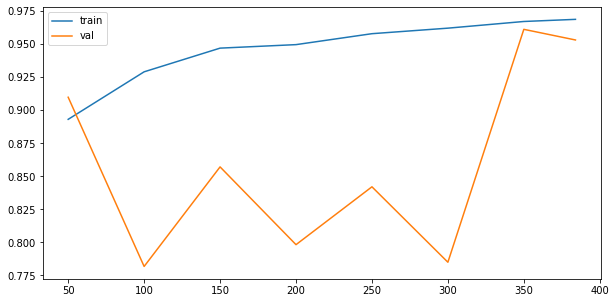

In [ ]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

# Show me the money 🤑

## Prices

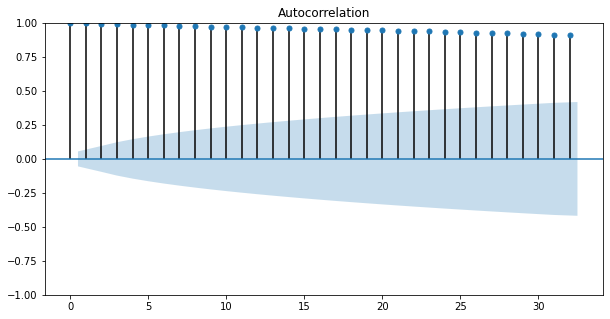

In [ ]:
plot_acf(prices['Adj Close']);

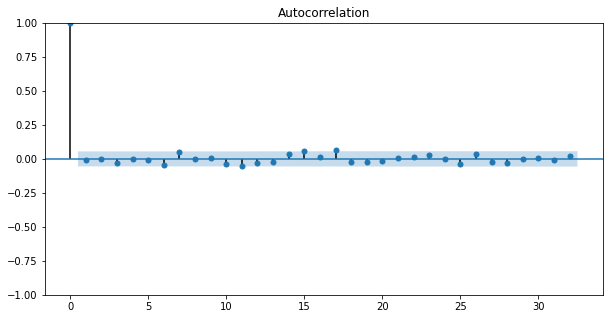

In [ ]:
plot_acf(prices['Adj Close'].diff().fillna(0));

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


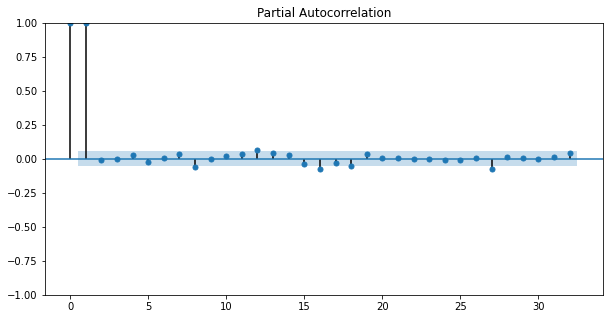

In [ ]:
plot_pacf(prices['Adj Close']);

### FE

In [ ]:
X = get_lags(pd.DataFrame(prices['Adj Close']), 7)
y = prices['Adj Close'].reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1006, 7)
(1006,)
(252, 7)
(252,)


In [ ]:
resultsprices = {}

## KNN

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=2, weights='distance')
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

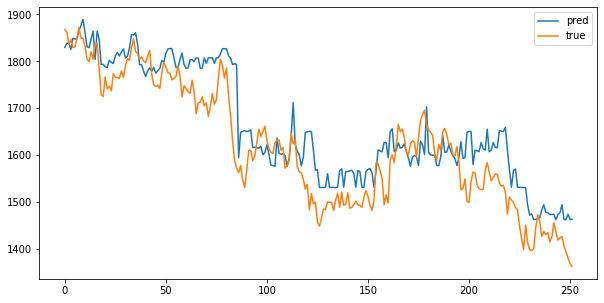

In [ ]:
pd.Series(y_pred).plot(label='pred')
y_test.reset_index(drop=True).plot(label='true')
plt.legend()

In [ ]:
print('Prices - KNN model Results')
print('r2' ,r2_score(neigh.predict(X_test), y_test))
print('mse' ,mean_squared_error(neigh.predict(X_test), y_test))
print('mae', mean_absolute_error(neigh.predict(X_test), y_test))
resultsprices['KNN'] = {'r2':r2_score(neigh.predict(X_test), y_test), \
                 'mse': mean_squared_error(neigh.predict(X_test), y_test), 
                 'mae': mean_absolute_error(neigh.predict(X_test), y_test)}

Prices - KNN model Results
r2 0.7096013960119982
mse 4210.650043299322
mae 52.80703192035267


In [ ]:
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [ ]:
neighd1 = KNeighborsRegressor(n_neighbors=2, weights='distance')
neighd1.fit(X_train_d1, y_train_d1)
y_pred_d1 = neighd1.predict(X_test_d1)

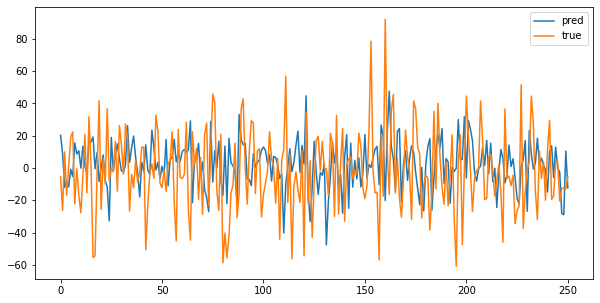

In [ ]:
pd.Series(y_pred_d1).plot(label='pred')
y_test_d1.reset_index(drop=True).plot(label='true')
plt.legend()

In [ ]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(neighd1.predict(X_test_d1).flatten(), name='prices'),axis=0)

In [ ]:
print('Prices pred_one - KNN model Results')
print(r2_score(pred_one.iloc[1:-1], y_test.iloc[1:-1]))
print(mean_squared_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]))
print(mean_absolute_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]))
resultsprices['KNN D1 ONE'] = {'r2':r2_score(pred_one.iloc[1:-1], y_test.iloc[1:-1]), \
                 'mse': mean_squared_error(pred_one.iloc[1:-1], y_test.iloc[1:-1]), 
                 'mae': mean_absolute_error(pred_one.iloc[1:-1], y_test.iloc[1:-1])}


Prices pred_one - KNN model Results
0.9495759221725417
854.7551648676425
22.534678606044853


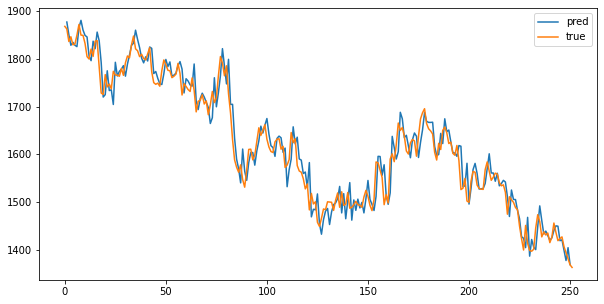

In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_one, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.legend()

## SVR

In [ ]:
regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

In [ ]:
regr.fit(X_train, y_train)

SVR(epsilon=0.2, kernel='linear')

In [ ]:
y_pred = regr.predict(X_test)

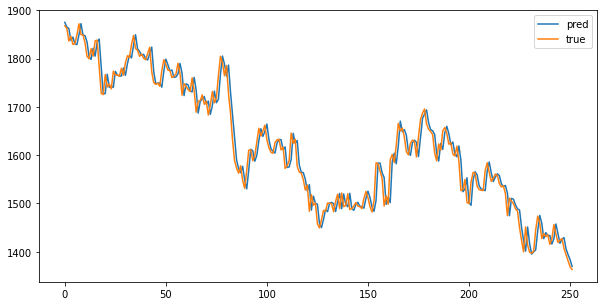

In [ ]:
pd.Series(y_pred).plot(label='pred')
y_test.reset_index(drop=True).plot(label='true')
plt.legend()

In [ ]:
print('Prices - SVR model Results')
print('r2' ,r2_score(y_pred, y_test))
print('mse' ,mean_squared_error(y_pred, y_test))
print('mae', mean_absolute_error(y_pred, y_test))
resultsprices['SVR'] = {'r2':r2_score(y_pred, y_test), \
                 'mse': mean_squared_error(y_pred, y_test), 
                 'mae': mean_absolute_error(y_pred, y_test)}

Prices - SVR model Results
r2 0.963271964236085
mse 613.071918661295
mae 19.234203976836564


Fiquei rico? 

Negociar ações é mais complicado do que fazer previsão de um passo a frente. 

O retorno geralmente ocorre a longo prazo, por isso um dos desafios é prever vários passos a frente.

In [ ]:
X_train

,Adj Close-1,Adj Close-2,Adj Close-3,Adj Close-4,Adj Close-5,Adj Close-6,Adj Close-7
Date,,,,,,,
2017-04-24,785.365479,773.101074,789.745789,795.439941,817.340698,809.456482,797.191956
2017-04-25,798.067932,785.365479,773.101074,789.745789,795.439941,817.340698,809.456482
2017-04-26,825.225159,798.067932,785.365479,773.101074,789.745789,795.439941,817.340698
2017-04-27,818.654846,825.225159,798.067932,785.365479,773.101074,789.745789,795.439941
2017-04-28,842.307800,818.654846,825.225159,798.067932,785.365479,773.101074,789.745789
...,...,...,...,...,...,...,...
2021-04-08,1892.730225,1907.099121,1839.218506,1807.507812,1799.580200,1770.895752,1786.681030
2021-04-09,1866.965332,1892.730225,1907.099121,1839.218506,1807.507812,1799.580200,1770.895752
2021-04-12,1845.164185,1866.965332,1892.730225,1907.099121,1839.218506,1807.507812,1799.580200


In [ ]:
get_lags(pd.DataFrame(prices['Adj Close']), -7)

,Adj Close+1,Adj Close+2,Adj Close+3,Adj Close+4,Adj Close+5,Adj Close+6,Adj Close+7
Date,,,,,,,
2017-04-11,809.456482,817.340698,795.439941,789.745789,773.101074,785.365479,798.067932
2017-04-12,817.340698,795.439941,789.745789,773.101074,785.365479,798.067932,825.225159
2017-04-13,795.439941,789.745789,773.101074,785.365479,798.067932,825.225159,818.654846
2017-04-18,789.745789,773.101074,785.365479,798.067932,825.225159,818.654846,842.307800
2017-04-19,773.101074,785.365479,798.067932,825.225159,818.654846,842.307800,859.390503
...,...,...,...,...,...,...,...
2022-03-25,1426.500000,1456.000000,1436.500000,1419.000000,1423.500000,1427.000000,1406.500000
2022-03-28,1456.000000,1436.500000,1419.000000,1423.500000,1427.000000,1406.500000,1394.000000
2022-03-29,1436.500000,1419.000000,1423.500000,1427.000000,1406.500000,1394.000000,1381.500000


In [ ]:
y_train_multi = get_lags(pd.DataFrame(y_train), -7)
y_test_multi = get_lags(pd.DataFrame(y_test), -7)

In [ ]:
X_train_multi, y_train_multi = X_train.align(y_train_multi, join='inner', axis=0) 
X_test_multi, y_test_multi = X_test.align(y_test_multi, join='inner', axis=0) 

In [ ]:
X_train_multi.index is y_train_multi.index

True

In [ ]:
X_test_multi.index is y_test_multi.index

True

In [ ]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
regr_multi = MultiOutputRegressor(LinearSVR(C=1.0, epsilon=0.2))

In [ ]:
regr_multi.fit(X_train_multi, y_train_multi)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

MultiOutputRegressor(estimator=LinearSVR(epsilon=0.2))

In [ ]:
y_pred_multi = regr_multi.predict(X_test_multi)

In [ ]:
regr_multi.predict(X_test_multi).shape

(245, 7)

In [ ]:
print('Prices - SVR multi model Results')
print('r2' ,r2_score(y_pred_multi, y_test_multi))
print('mse' ,mean_squared_error(y_pred_multi, y_test_multi))
print('mae', mean_absolute_error(y_pred_multi, y_test_multi))
resultsprices['SVR multi'] = {'r2':r2_score(y_pred_multi, y_test_multi), \
                 'mse': mean_squared_error(y_pred_multi, y_test_multi), 
                 'mae': mean_absolute_error(y_pred_multi, y_test_multi)}

Prices - SVR multi model Results
r2 0.3627946541123513
mse 9065.061796620957
mae 77.19764370745118


In [ ]:
  np.random.randint(1,100,5)

array([17, 40, 65, 34, 22])

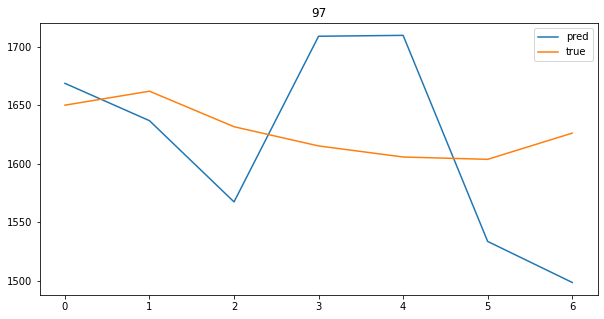

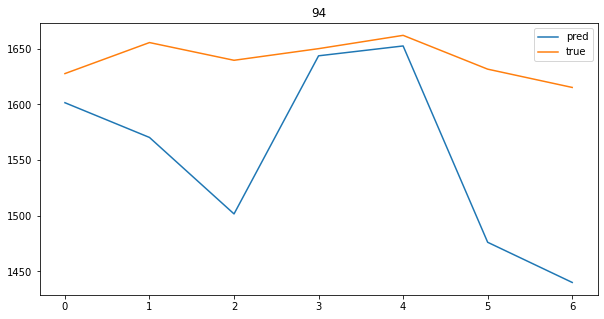

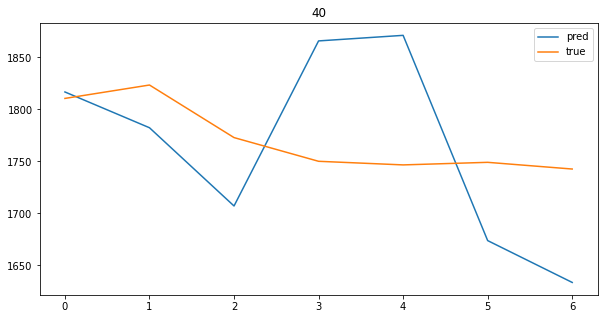

In [ ]:
for day in np.random.randint(1,100,3):
  fig, ax = plt.subplots()
  pd.Series(y_pred_multi[day]).plot(label='pred')
  pd.Series(pd.DataFrame(y_test_multi).reset_index(drop=True).loc[day].values).plot(label='true')
  plt.title(day)
  plt.legend()

In [ ]:
pd.DataFrame(resultsprices)

,KNN,KNN D1 ONE,SVR,SVR multi
r2,0.709601,0.949576,0.963272,0.362795
mse,4210.650043,854.755165,613.071919,9065.061797
mae,52.807032,22.534679,19.234204,77.197644


## MLP

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

https://pytorch.org/tutorials/beginner/basics/intro.html

### Graphs

In [ ]:
!sudo apt-get install graphviz graphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2

In [ ]:
pip install pygraphviz

     |████████████████████████████████| 118 kB 5.2 MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165752 sha256=8e322f4f928f86ed84946dfaa7ff2b60b0d19e836a696d46e41361cef7630d80
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [ ]:
import pygraphviz

In [ ]:
import networkx as nx

In [ ]:
g1 = nx.DiGraph()
for i in range(1,6):
  g1.add_edge(i,'n1')
g1.add_edge('n1','out')
A = nx.nx_agraph.to_agraph(g1)
A.draw("g1.png", prog="dot", )

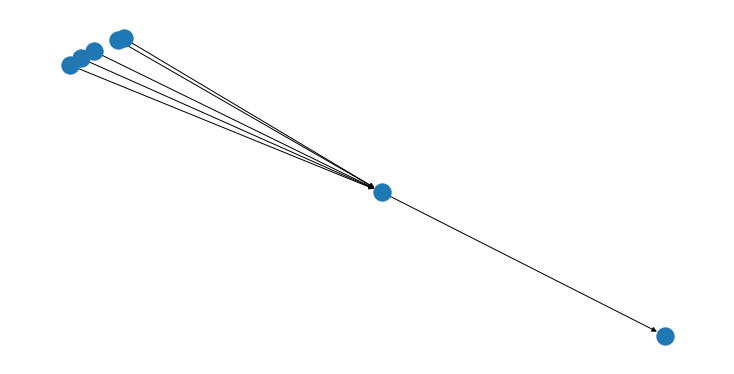

In [ ]:
nx.draw_kamada_kawai(g1)

In [ ]:
camada entrada = [1,2,3,4]
neuronios = [1,2,3,4][1,2,3,4][1,2,3,4]
ativacao = relu(neuronios)
output = ativacao

erro = grad(neuronios)


In [ ]:
g2 = nx.DiGraph()
"""
# X
for i in range(1,5):
  g2.add_node(i)

# y
g2.add_node('out')

# Neurons
for j in ('n1','n2','n3'):
  g2.add_node(j)
"""
# Conexões
for i in range(1,5):
  for j in ('n1','n2','n3'):
    g2.add_edge(i,j)
    g2.add_edge(j,'out')
B = nx.nx_agraph.to_agraph(g2)
B.draw("g2.png", prog="dot")

In [ ]:
g3 = g2.reverse()
C = nx.nx_agraph.to_agraph(g3)
C.draw("g3.png", prog="dot")

In [ ]:
g4 = nx.DiGraph()
# Conexões
for i in range(1,5):
  for j in ('n11','n12','n13'):
    g4.add_edge(i,j)
    for k in ('n21','n22','n23', 'n24', 'n25'):
      g4.add_edge(j,k)
      for l in ('n31','n32','n33', 'n34', 'n35', 'n36', 'n37'):
        g4.add_edge(k,l)
        g4.add_edge(l,'out')
D = nx.nx_agraph.to_agraph(g4)
D.draw("g4.png", prog="dot")

### Normalization

In [ ]:
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

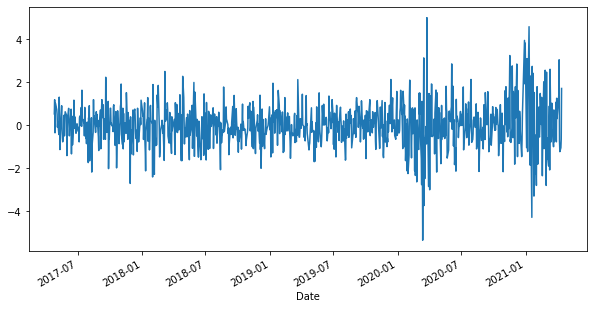

In [ ]:
X_train_d1_norm['Adj Close-1'].plot()

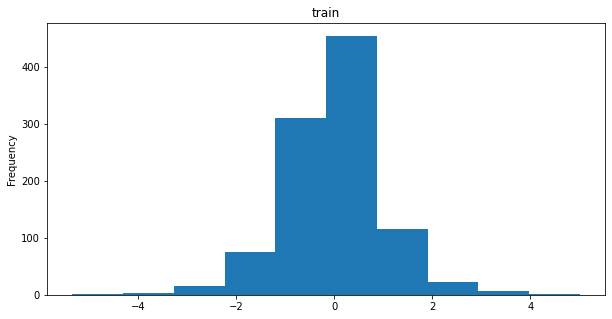

In [ ]:
X_train_d1_norm['Adj Close-1'].plot.hist(title='train')

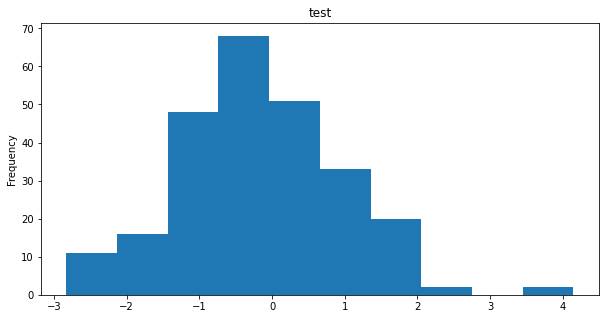

In [ ]:
X_test_d1_norm['Adj Close-1'].plot.hist(title='test')

### Tensors

![](https://miro.medium.com/max/654/1*8jdzMrA33Leu3j3F6A8a3w.png)

#### Batches

In [ ]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)

In [ ]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

### ANN

In [ ]:
class OP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(7,1)
    
  def forward(self, X):
    out = torch.relu(self.fc(X))
    return out

In [ ]:
one_neuron = OP()
print(one_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([0.], grad_fn=<ReluBackward0>)
27.1572265625


In [ ]:
one_neuron = OP()
epochs = 50
loss_fn = nn.MSELoss()
optimizer = optim.SGD(one_neuron.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch1, loss 481.0567878844246
Epoch2, loss 479.70575362916975
Epoch3, loss 478.24449412027997
Epoch4, loss 477.13922542995874
Epoch5, loss 476.2566898890904
Epoch6, loss 475.54496232290114
Epoch7, loss 474.969111487979
Epoch8, loss 474.5033505152142
Epoch9, loss 474.1263041420588
Epoch10, loss 473.8192308213976
Epoch11, loss 473.56562671964133
Epoch12, loss 473.35308135501924
Epoch13, loss 473.1743895515563
Epoch14, loss 473.02565402076357
Epoch15, loss 472.89960128541975
Epoch16, loss 472.7925800141834
Epoch17, loss 472.7019750201513
Epoch18, loss 472.6235789949932
Epoch19, loss 472.55550977918836
Epoch20, loss 472.49633050343346
Epoch21, loss 472.4452331785172
Epoch22, loss 472.4000984070793
Epoch23, loss 472.3603751772926
Epoch24, loss 472.32577732631137
Epoch25, loss 472.296009729779
Epoch26, loss 472.2694876534598
Epoch27, loss 472.24459693545384
Epoch28, loss 472.2228824676029
Epoch29, loss 472.20210907951235
Epoch30, loss 472.18195669991627
Epoch31, loss 472.16216932024275
Epoc

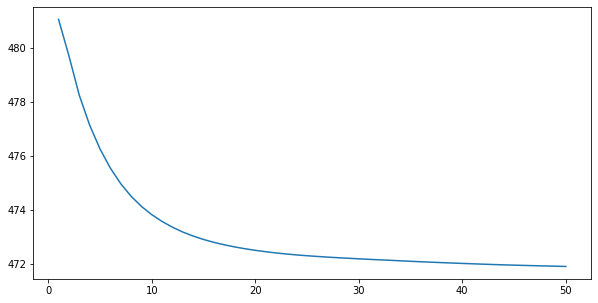

In [ ]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:7].float()
    y = train_data[:,7].float()
  
    #forward pass
    outputs = one_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()



In [ ]:
one_neuron.eval() #desliga o treinamento do modelo
results = []
for test_data in test_dataloader:
    x = test_data[:,:7].float()
    y = test_data[:,7].float()
    
    y_pred = one_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results[:10]

[0.0, 0.0, 0.0, 0.006098807, 0.0, 0.0, 0.0, 1.4480712, 0.0, 1.3532414]

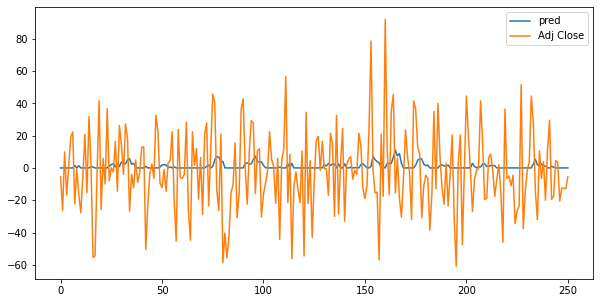

In [ ]:
pd.concat([pd.Series(results, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [ ]:
print('Prices - OP Results')
print('r2' ,r2_score(results, y_test_d1))
print('mse' ,mean_squared_error(results, y_test_d1))
print('mae', mean_absolute_error(results, y_test_d1))
resultsprices['OP'] = {'r2':r2_score(results, y_test_d1), \
                 'mse': mean_squared_error(results, y_test_d1), 
                 'mae': mean_absolute_error(results, y_test_d1)}

Prices - OP Results
r2 -187.2816446022491
mse 628.265283711631
mae 19.57882738707075


In [ ]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(7,100)
    self.fc3 = nn.Linear(100,1)
    #self.drop1 = nn.Dropout(p=0.5)
    #self.fc2 = nn.Linear(64,32)
    #self.drop2 = nn.Dropout(p=0.5)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    #out = self.drop1(out)
    #out = torch.relu(self.fc2(out))
    #out = self.drop2(out)
    out = self.fc3(out)
    return out

In [ ]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([-0.6459], grad_fn=<AddBackward0>)
27.1572265625


In [ ]:
multi_neuron = MLP()
epochs = 1000
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([13])) that is different to the input size (torch.Size([13, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch10, loss 472.1953005109514
Epoch20, loss 469.98317173549106
Epoch30, loss 468.27874380444723
Epoch40, loss 467.10897391183033
Epoch50, loss 466.0652768574064
Epoch60, loss 464.9838499038938
Epoch70, loss 464.10504671127075
Epoch80, loss 463.339724465022
Epoch90, loss 462.66132100423175
Epoch100, loss 461.9160196213495
Epoch110, loss 461.268919081915
Epoch120, loss 460.6972982013036
Epoch130, loss 460.1857552906824
Epoch140, loss 459.80941724020335
Epoch150, loss 459.4679807632688
Epoch160, loss 459.08869122701975
Epoch170, loss 458.7442687503875
Epoch180, loss 458.4001179044209
Epoch190, loss 458.0741125439841
Epoch200, loss 457.79850320967415
Epoch210, loss 457.5490692380875
Epoch220, loss 457.2989738101051
Epoch230, loss 457.08313920762805
Epoch240, loss 456.88528018527563
Epoch250, loss 456.6995571075924
Epoch260, loss 456.47628723628935
Epoch270, loss 456.2558312794519
Epoch280, loss 456.08224087669737
Epoch290, loss 455.90626646980405
Epoch300, loss 455.7371903676835
Epoch310

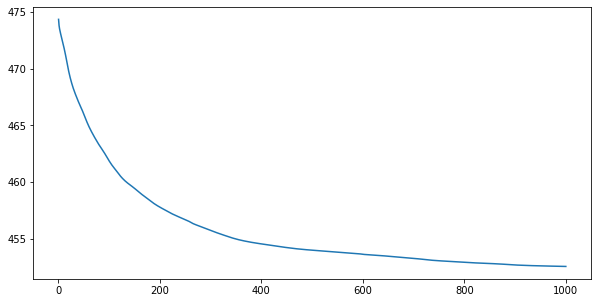

In [ ]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:7].float()
    y = train_data[:,7].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  if (epoch % 10 == 0):
    print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()



In [ ]:
multi_neuron.eval()
results = []
for test_data in test_dataloader:
    x = test_data[:,:7].float()
    y = test_data[:,7].float()
    
    y_pred = multi_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results[:10]

[1.2869357,
 -0.5590868,
 3.8070354,
 3.2451992,
 1.5999026,
 7.0172415,
 -0.019789696,
 -1.6551976,
 -0.81843805,
 1.5772028]

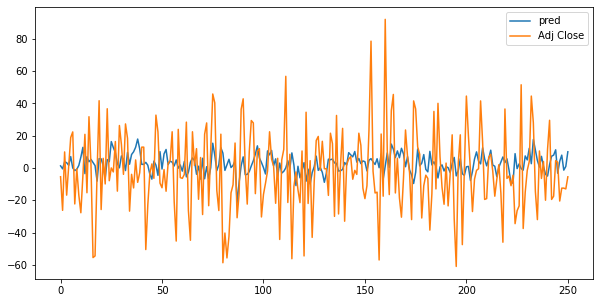

In [ ]:
pd.concat([pd.Series(results, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [89]:
print('Prices - MLP Results')
print('r2' ,r2_score(results, y_test_d1))
print('mse' ,mean_squared_error(results, y_test_d1))
print('mae', mean_absolute_error(results, y_test_d1))
results['MLP'] = {'r2':r2_score(results, y_test_d1), \
                 'mse': mean_squared_error(results, y_test_d1), 
                 'mae': mean_absolute_error(results, y_test_d1)}

Prices - MLP Results


NameError: name 'results' is not defined

In [90]:
pd.DataFrame(results)

NameError: name 'resultsprices' is not defined

Redes recorrentes:
* LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
* GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU
